In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import os


In [ ]:
# Set workspace 
workspace_path = r"C:\Users\kaefer\Desktop\Schulemappe\Master\MasterEBusiness\E Business Seminar\NAB-master"
os.chdir(workspace_path)
print(f"Current working directory: {os.getcwd()}")

Current working directory: C:\Users\kaefer\Desktop\Schulemappe\Master\MasterEBusiness\E Business Seminar\NAB-master


In [ ]:
#Load Dataset
path = "data//artificialNoAnomaly//art_daily_small_noise.csv"
df = pd.read_csv(path, parse_dates=["timestamp"])
time = df['timestamp']
demand = df['value'].values

df["timestamp"] = pd.to_datetime(df["timestamp"])  # Ensure proper datetime format
df.set_index("timestamp", inplace=True)  # Set as index


In [ ]:
#Normalize Data for LSTM
scaler = MinMaxScaler()
df["scaled_value"] = scaler.fit_transform(df[["value"]])

In [ ]:
#Prepare Data for LSTM (Convert to Sequences)
sequence_length = 10  # Lookback window
X, y = [], []
for i in range(len(df) - sequence_length):
    X.append(df["scaled_value"].iloc[i:i + sequence_length].values)
    y.append(df["scaled_value"].iloc[i + sequence_length])

X, y = np.array(X), np.array(y)

In [ ]:
#Train LSTM Model
model = Sequential([
    LSTM(50, activation="relu", return_sequences=False, input_shape=(sequence_length, 1)),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.fit(X, y, epochs=50, batch_size=8, verbose=0)

C:\Users\kaefer\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Forecast Future Values
predictions = model.predict(X)
df["forecast"] = np.nan
df.iloc[sequence_length:, df.columns.get_loc("forecast")] = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [9]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df.dropna(subset=["forecast"], inplace=True)  # Remove NaNs before fitting model
df["anomaly"] = iso_forest.fit_predict(df[["forecast"]]) == -1


In [ ]:
#Anomaly Mitigation Interpolation
df["smoothed_value"] = df["value"]
df.loc[df["anomaly"], "smoothed_value"] = np.nan  # Replace anomalies with NaN
df["smoothed_value"] = df["smoothed_value"].interpolate(method="time") #due to unexpected behavior decided to use time interpolation for all tests


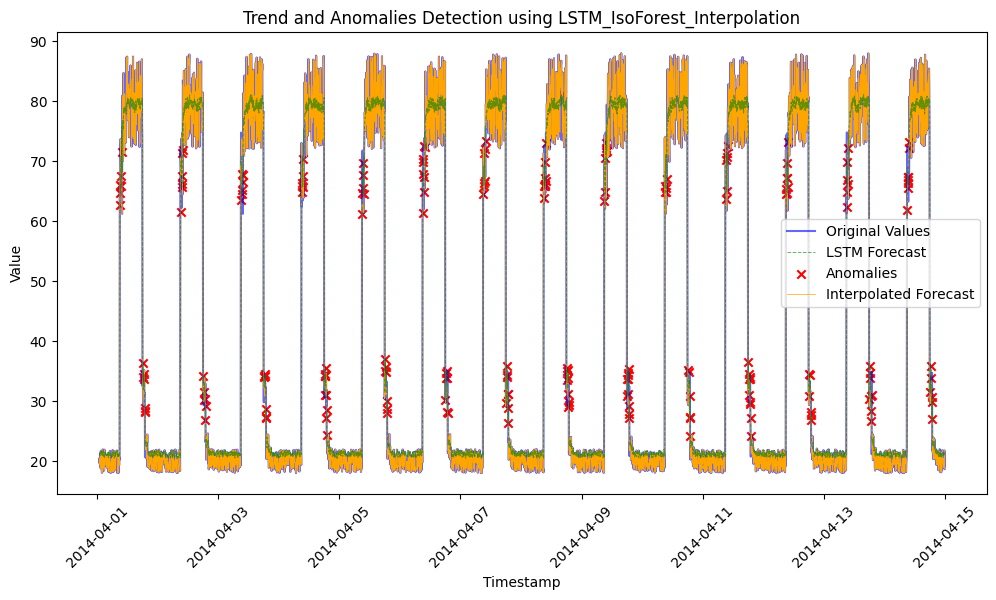

In [11]:
# **Plot Results**
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["value"], label="Original Values", color="blue", alpha=0.6)
plt.plot(df.index, df["forecast"], label="LSTM Forecast", linestyle="dashed", color="green", alpha=0.6, zorder = 3, linewidth= 0.7)
plt.scatter(df.index[df["anomaly"]], df["forecast"][df["anomaly"]], color="red", label="Anomalies", marker="x")
plt.plot(df.index, df["smoothed_value"], label="Interpolated Forecast", color="orange", linewidth=0.5)
plt.title("Trend and Anomalies Detection using LSTM_IsoForest_Interpolation")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation=45)
plt.show()

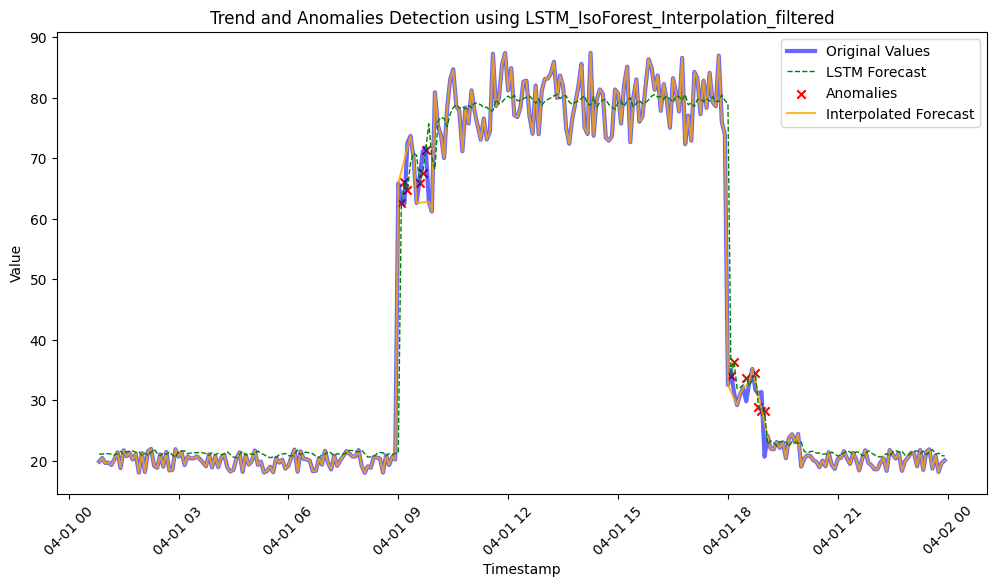

In [12]:
# Filter the dataset for the specific date range
start_date = "2014-04-01"
end_date = "2014-04-01"
df_filtered = df.loc[start_date:end_date]

# Plot only the filtered date range
plt.figure(figsize=(12, 6))
plt.plot(df_filtered.index, df_filtered["value"], label="Original Values", color="blue", alpha=0.6, linewidth= 3)
plt.plot(df_filtered.index, df_filtered["forecast"], label="LSTM Forecast", linestyle="dashed", color="green", alpha=1, zorder = 3, linewidth= 1.0)
plt.scatter(df_filtered.index[df_filtered["anomaly"]], df_filtered["forecast"][df_filtered["anomaly"]], 
            color="red", label="Anomalies", marker="x")
plt.plot(df_filtered.index, df_filtered["smoothed_value"], label="Interpolated Forecast", color="orange", linewidth=1.5, alpha = 0.8)
plt.title("Trend and Anomalies Detection using LSTM_IsoForest_Interpolation_filtered")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [13]:
print(df[df["anomaly"] == True])


                         value  scaled_value   forecast  anomaly  \
timestamp                                                          
2014-04-01 09:05:00  63.030237      0.643504  62.629189     True   
2014-04-01 09:10:00  62.484097      0.635699  66.010559     True   
2014-04-01 09:15:00  72.508649      0.778958  64.732544     True   
2014-04-01 09:35:00  66.667570      0.695484  65.869446     True   
2014-04-01 09:40:00  71.113573      0.759021  67.513916     True   
...                        ...           ...        ...      ...   
2014-04-14 18:30:00  34.613994      0.237413  33.890614     True   
2014-04-14 18:35:00  29.468668      0.163882  35.854858     True   
2014-04-14 18:50:00  29.412821      0.163084  29.822218     True   
2014-04-14 18:55:00  34.704457      0.238706  27.027159     True   
2014-04-14 19:00:00  22.706754      0.067249  30.623480     True   

                     smoothed_value  
timestamp                            
2014-04-01 09:05:00       67.818407  
2

In [14]:
#complet neue froecasting mit neuen werten

In [ ]:
#Normalize Data for LSTM
scaler = MinMaxScaler()
df["scaled_value_smoothed"] = scaler.fit_transform(df[["smoothed_value"]])

In [ ]:
#Prepare Data for LSTM (Convert to Sequences)
sequence_length = 10  # Lookback window
X, y = [], []
for i in range(len(df) - sequence_length):
    X.append(df["scaled_value_smoothed"].iloc[i:i + sequence_length].values)
    y.append(df["scaled_value_smoothed"].iloc[i + sequence_length])

X, y = np.array(X), np.array(y)


In [ ]:
#Forecast Future Values
predictions = model.predict(X)
df["forecast_smoothed"] = np.nan
df.iloc[sequence_length:, df.columns.get_loc("forecast_smoothed")] = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step


In [ ]:
#Train LSTM Model
model = Sequential([
    LSTM(50, activation="relu", return_sequences=False, input_shape=(sequence_length, 1)),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.fit(X, y, epochs=50, batch_size=8, verbose=0)


C:\Users\kaefer\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
# **Step 3: Anomaly Detection on Smoothed (Interpolated) Values**
df["smoothed_anomaly"] = iso_forest.fit_predict(df[["forecast_smoothed"]]) == -1  # Re-run anomaly detection

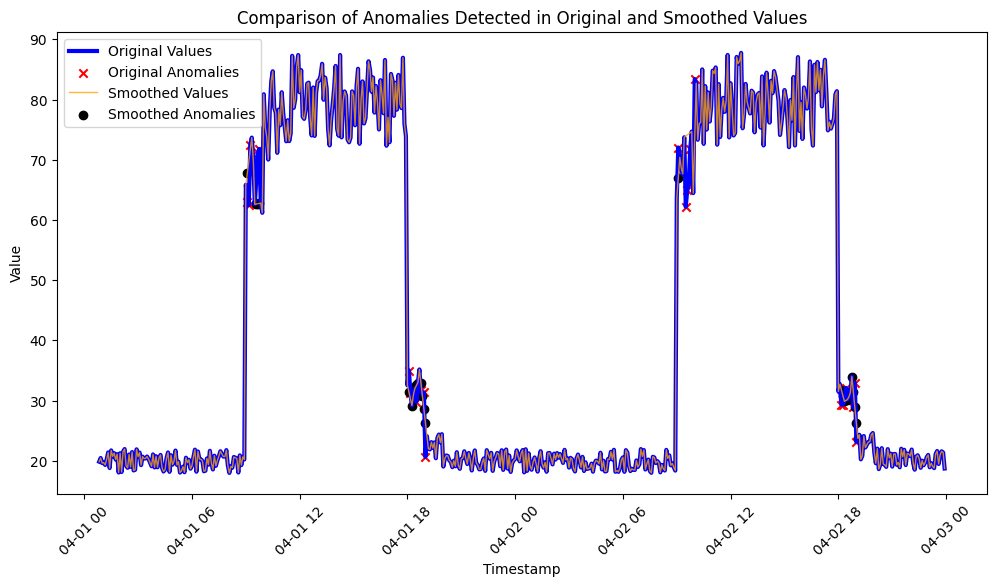

Original Anomalies Detected: 201
Smoothed Anomalies Detected: 201
Anomalies Reduced: 0


In [ ]:
start_date = "2014-04-01"
end_date = "2014-04-02"
df_filtered = df.loc[start_date:end_date]


plt.figure(figsize=(12, 6))

plt.plot(df_filtered.index, df_filtered["value"], label="Original Values", color="blue", alpha=1,linewidth= 3)
plt.scatter(df_filtered.index[df_filtered["anomaly"]], df_filtered["value"][df_filtered["anomaly"]], color="red", label="Original Anomalies", marker="x")

plt.plot(df_filtered.index, df_filtered["smoothed_value"], label="Smoothed Values", color="orange", linewidth=1, zorder = 3, alpha = 0.8)
plt.scatter(df_filtered.index[df_filtered["smoothed_anomaly"]], df_filtered["smoothed_value"][df_filtered["smoothed_anomaly"]], color="black", label="Smoothed Anomalies", marker="o")

plt.title("Comparison of Anomalies Detected in Original and Smoothed Values")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation=45)
plt.show()

original_anomalies_count = df["anomaly"].sum()
smoothed_anomalies_count = df["smoothed_anomaly"].sum()

print(f"Original Anomalies Detected: {original_anomalies_count}")
print(f"Smoothed Anomalies Detected: {smoothed_anomalies_count}")
print(f"Anomalies Reduced: {original_anomalies_count - smoothed_anomalies_count}")

In [21]:
df

,value,scaled_value,forecast,anomaly,smoothed_value,scaled_value_smoothed,forecast_smoothed,smoothed_anomaly
timestamp,,,,,,,,
2014-04-01 00:50:00,19.870725,0.026720,21.122236,False,19.870725,0.026720,NaN,False
2014-04-01 00:55:00,20.477560,0.035392,21.085548,False,20.477560,0.035392,NaN,False
2014-04-01 01:00:00,19.644762,0.023491,21.240055,False,19.644762,0.023491,NaN,False
2014-04-01 01:05:00,19.709946,0.024423,21.173956,False,19.709946,0.024423,NaN,False
2014-04-01 01:10:00,19.321139,0.018866,21.090824,False,19.321139,0.018866,NaN,False
...,...,...,...,...,...,...,...,...
2014-04-14 23:35:00,20.211195,0.031586,20.959751,False,20.211195,0.031586,20.959751,False
2014-04-14 23:40:00,20.531041,0.036157,21.155388,False,20.531041,0.036157,21.155388,False
2014-04-14 23:45:00,19.032127,0.014736,21.300848,False,19.032127,0.014736,21.300848,False


In [22]:
original_variance = np.var(df["value"])
smoothed_variance = np.var(df["smoothed_value"])

print(f"Original Variance: {original_variance:.4f}")
print(f"Smoothed Variance: {smoothed_variance:.4f}")
print(f"Variance Reduction: {original_variance - smoothed_variance:.4f}")

Original Variance: 788.8906
Smoothed Variance: 787.5557
Variance Reduction: 1.3349
